In [2]:
# Cell 1: Setup und Imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Projektpfad hinzufügen
sys.path.append('/app')

# Unseren Data Loader importieren
from python.data_loader import TickDataLoader

print("✅ Alle Imports erfolgreich")
print(f"Verfügbare Daten in: {Path('/app/data/processed/').exists()}")

🔧 Config loaded - DEV_MODE: False, MOVE_FILES: True
✅ Alle Imports erfolgreich
Verfügbare Daten in: True


In [3]:
# Cell 2: Data Loader initialisieren und Übersicht
loader = TickDataLoader('/app/data/processed/')

# Verfügbare Symbole anzeigen
symbols = loader.list_available_symbols()
print("🎯 Verfügbare Symbole:", symbols)

# Daten-Zusammenfassung
summary = loader.get_data_summary()
for symbol, info in summary.items():
    if 'error' not in info:
        print(f"\n📊 {symbol}:")
        print(f"   📈 {info['total_ticks']:,} Ticks")
        print(f"   📅 {info['date_range']['days']} Tage")
        print(f"   💾 {info['file_size_mb']:.1f} MB")
        print(f"   ⚡ {info['statistics']['tick_frequency_per_second']:.1f} Ticks/Sek")

2025-09-23 10:56:11,513 - INFO - Erstelle Übersicht für 4 Symbole...


🎯 Verfügbare Symbole: ['AUDUSD', 'EURUSD', 'GBPUSD', 'USDJPY']

📊 AUDUSD:
   📈 155,727 Ticks
   📅 2 Tage
   💾 3.1 MB
   ⚡ 0.8 Ticks/Sek

📊 EURUSD:
   📈 190,912 Ticks
   📅 3 Tage
   💾 3.8 MB
   ⚡ 0.7 Ticks/Sek

📊 GBPUSD:
   📈 247,795 Ticks
   📅 2 Tage
   💾 4.7 MB
   ⚡ 1.4 Ticks/Sek

📊 USDJPY:
   📈 293,378 Ticks
   📅 2 Tage
   💾 5.5 MB
   ⚡ 1.6 Ticks/Sek


In [4]:
# Cell 3: EURUSD Daten laden und erste Analyse
eurusd_data = loader.load_symbol_data("EURUSD")

print("🔍 EURUSD Daten geladen:")
print(f"   Anzahl Ticks: {len(eurusd_data):,}")
print(f"   Zeitspanne: {eurusd_data['timestamp'].min()} bis {eurusd_data['timestamp'].max()}")
print(f"   Spalten: {list(eurusd_data.columns)}")

# Erste 5 Zeilen anzeigen
print("\n📋 Erste 5 Ticks:")
eurusd_data.head()

2025-09-23 10:58:24,075 - INFO - Lade 5 Dateien für EURUSD
2025-09-23 10:58:24,411 - INFO - ✓ Geladen: 94,861 Ticks für EURUSD


🔍 EURUSD Daten geladen:
   Anzahl Ticks: 94,861
   Zeitspanne: 2025-09-16 22:39:06+00:00 bis 2025-09-19 23:56:46+00:00
   Spalten: ['timestamp', 'time_msc', 'bid', 'ask', 'last', 'tick_volume', 'real_volume', 'chart_tick_volume', 'spread_points', 'spread_pct', 'tick_flags', 'session', 'server_time']

📋 Erste 5 Ticks:


,timestamp,time_msc,bid,ask,last,tick_volume,real_volume,chart_tick_volume,spread_points,spread_pct,tick_flags,session,server_time
1,2025-09-16 22:39:06+00:00,1758062346650,1.18598,1.18610,0.0,0,0,5,11,0.010118,BID ASK,sydney_tokyo,2025.09.16 22:39:06
4,2025-09-16 22:39:07+00:00,1758062347905,1.18593,1.18606,0.0,0,0,8,12,0.010962,BID ASK,sydney_tokyo,2025.09.16 22:39:07
5,2025-09-16 22:39:08+00:00,1758062348023,1.18594,1.18606,0.0,0,0,9,11,0.010119,BID,sydney_tokyo,2025.09.16 22:39:08
6,2025-09-16 22:39:09+00:00,1758062349068,1.18592,1.18607,0.0,0,0,10,14,0.012648,BID ASK,sydney_tokyo,2025.09.16 22:39:09
7,2025-09-16 22:39:10+00:00,1758062350923,1.18590,1.18605,0.0,0,0,11,15,0.012649,BID ASK,sydney_tokyo,2025.09.16 22:39:10


In [5]:
# Cell 4: Basic Statistiken
print("📊 EURUSD Statistiken:")
print(f"   Bid Range: {eurusd_data['bid'].min():.5f} - {eurusd_data['bid'].max():.5f}")
print(f"   Ask Range: {eurusd_data['ask'].min():.5f} - {eurusd_data['ask'].max():.5f}")
print(f"   Durchschn. Spread: {eurusd_data['spread_points'].mean():.1f} Punkte")

# Beschreibende Statistiken
eurusd_data[['bid', 'ask', 'spread_points', 'spread_pct']].describe()

📊 EURUSD Statistiken:
   Bid Range: 1.17282 - 1.19178
   Ask Range: 1.17295 - 1.19192
   Durchschn. Spread: 12.9 Punkte


,bid,ask,spread_points,spread_pct
count,94861.000000,94861.000000,94861.000000,94861.000000
mean,1.178868,1.179002,12.890324,0.011381
std,0.003335,0.003338,5.265531,0.004432
min,1.172820,1.172950,11.000000,0.010072
25%,1.176330,1.176450,11.000000,0.010183
50%,1.178340,1.178480,12.000000,0.010215
75%,1.181600,1.181750,14.000000,0.011840
max,1.191780,1.191920,107.000000,0.091653


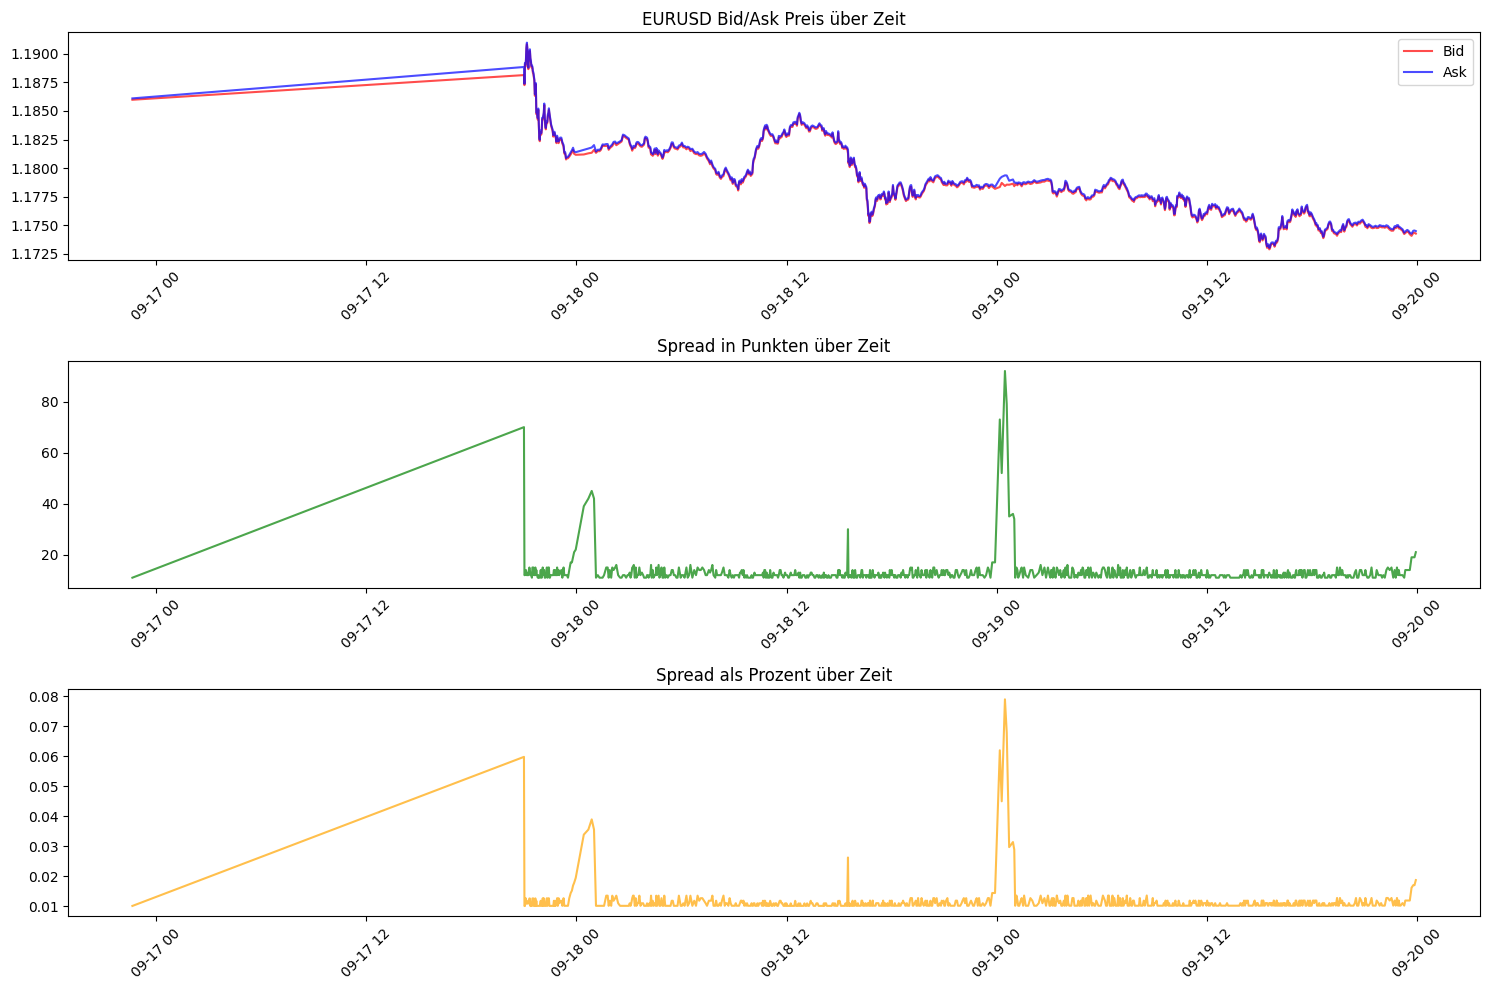

📈 Visualisierung basiert auf 949 Datenpunkten (jeder 100.)


In [6]:
# Cell 5: Erste Visualisierung - Preisbewegungen
plt.figure(figsize=(15, 10))

# Subplot 1: Bid/Ask über Zeit
plt.subplot(3, 1, 1)
sample_data = eurusd_data.iloc[::100]  # Jeden 100. Tick für Performance
plt.plot(sample_data['timestamp'], sample_data['bid'], label='Bid', alpha=0.7, color='red')
plt.plot(sample_data['timestamp'], sample_data['ask'], label='Ask', alpha=0.7, color='blue')
plt.title('EURUSD Bid/Ask Preis über Zeit')
plt.legend()
plt.xticks(rotation=45)

# Subplot 2: Spread in Punkten
plt.subplot(3, 1, 2)
plt.plot(sample_data['timestamp'], sample_data['spread_points'], color='green', alpha=0.7)
plt.title('Spread in Punkten über Zeit')
plt.xticks(rotation=45)

# Subplot 3: Spread als Prozent
plt.subplot(3, 1, 3)
plt.plot(sample_data['timestamp'], sample_data['spread_pct'], color='orange', alpha=0.7)
plt.title('Spread als Prozent über Zeit')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"📈 Visualisierung basiert auf {len(sample_data):,} Datenpunkten (jeder 100.)")

/tmp/ipykernel_3971/3695290531.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([eurusd_data['spread_points']], labels=['Spread Points'])


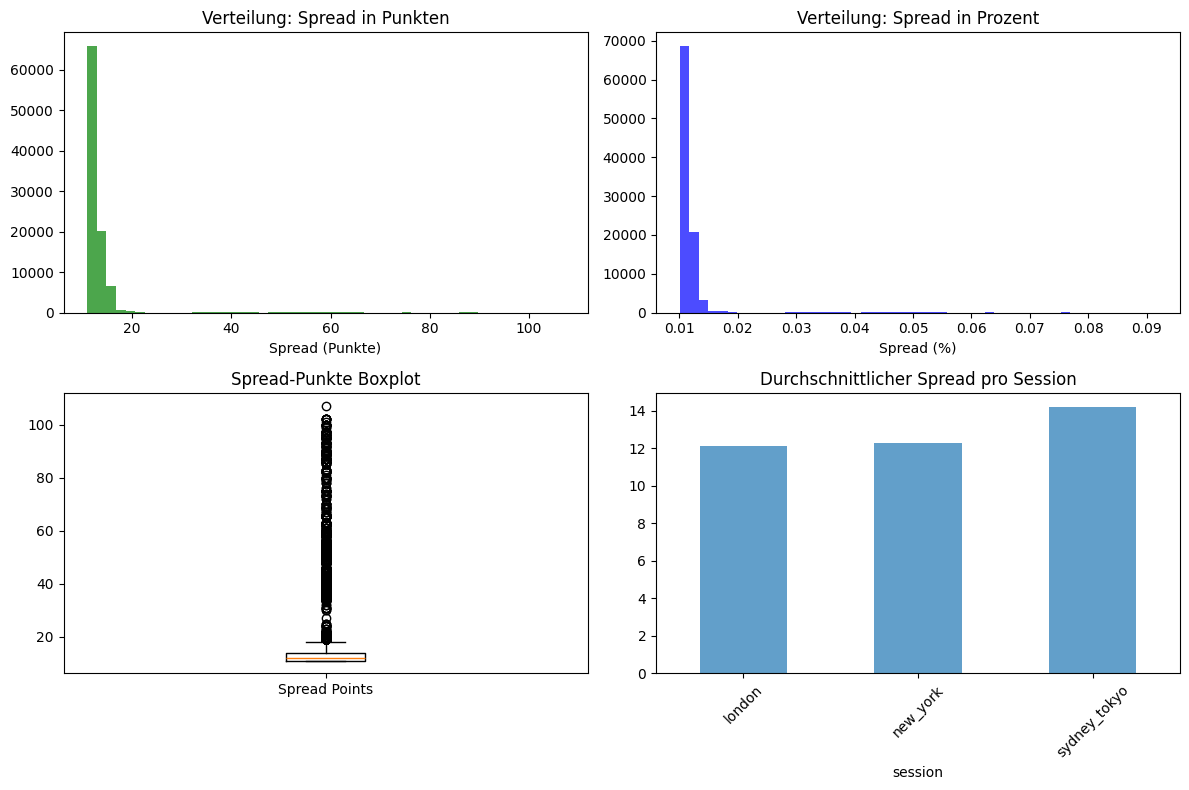

📊 Spread-Statistiken:
   Min Spread: 11 Punkte
   Max Spread: 107 Punkte
   Median: 12.0 Punkte


In [7]:
# Cell 6: Spread-Analyse (Datenqualitäts-Check)
plt.figure(figsize=(12, 8))

# Spread-Verteilung
plt.subplot(2, 2, 1)
plt.hist(eurusd_data['spread_points'], bins=50, alpha=0.7, color='green')
plt.title('Verteilung: Spread in Punkten')
plt.xlabel('Spread (Punkte)')

# Spread-Prozent-Verteilung  
plt.subplot(2, 2, 2)
plt.hist(eurusd_data['spread_pct'], bins=50, alpha=0.7, color='blue')
plt.title('Verteilung: Spread in Prozent')
plt.xlabel('Spread (%)')

# Boxplot Spreads
plt.subplot(2, 2, 3)
plt.boxplot([eurusd_data['spread_points']], labels=['Spread Points'])
plt.title('Spread-Punkte Boxplot')

# Session-basierte Spread-Analyse
plt.subplot(2, 2, 4)
if 'session' in eurusd_data.columns:
    session_spreads = eurusd_data.groupby('session')['spread_points'].mean()
    session_spreads.plot(kind='bar', alpha=0.7)
    plt.title('Durchschnittlicher Spread pro Session')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'Session-Daten nicht verfügbar', ha='center', va='center')
    plt.title('Session-Analyse')

plt.tight_layout()
plt.show()

print(f"📊 Spread-Statistiken:")
print(f"   Min Spread: {eurusd_data['spread_points'].min()} Punkte")
print(f"   Max Spread: {eurusd_data['spread_points'].max()} Punkte") 
print(f"   Median: {eurusd_data['spread_points'].median():.1f} Punkte")

2025-09-23 11:00:56,840 - INFO - Verwende gecachte Daten für EURUSD
2025-09-23 11:00:56,864 - INFO - Lade 5 Dateien für GBPUSD
2025-09-23 11:00:57,200 - INFO - ✓ Geladen: 108,318 Ticks für GBPUSD
2025-09-23 11:00:57,219 - INFO - Lade 6 Dateien für USDJPY
2025-09-23 11:00:57,553 - INFO - ✓ Geladen: 119,876 Ticks für USDJPY
2025-09-23 11:00:57,570 - INFO - Lade 4 Dateien für AUDUSD
2025-09-23 11:00:57,710 - INFO - ✓ Geladen: 82,827 Ticks für AUDUSD


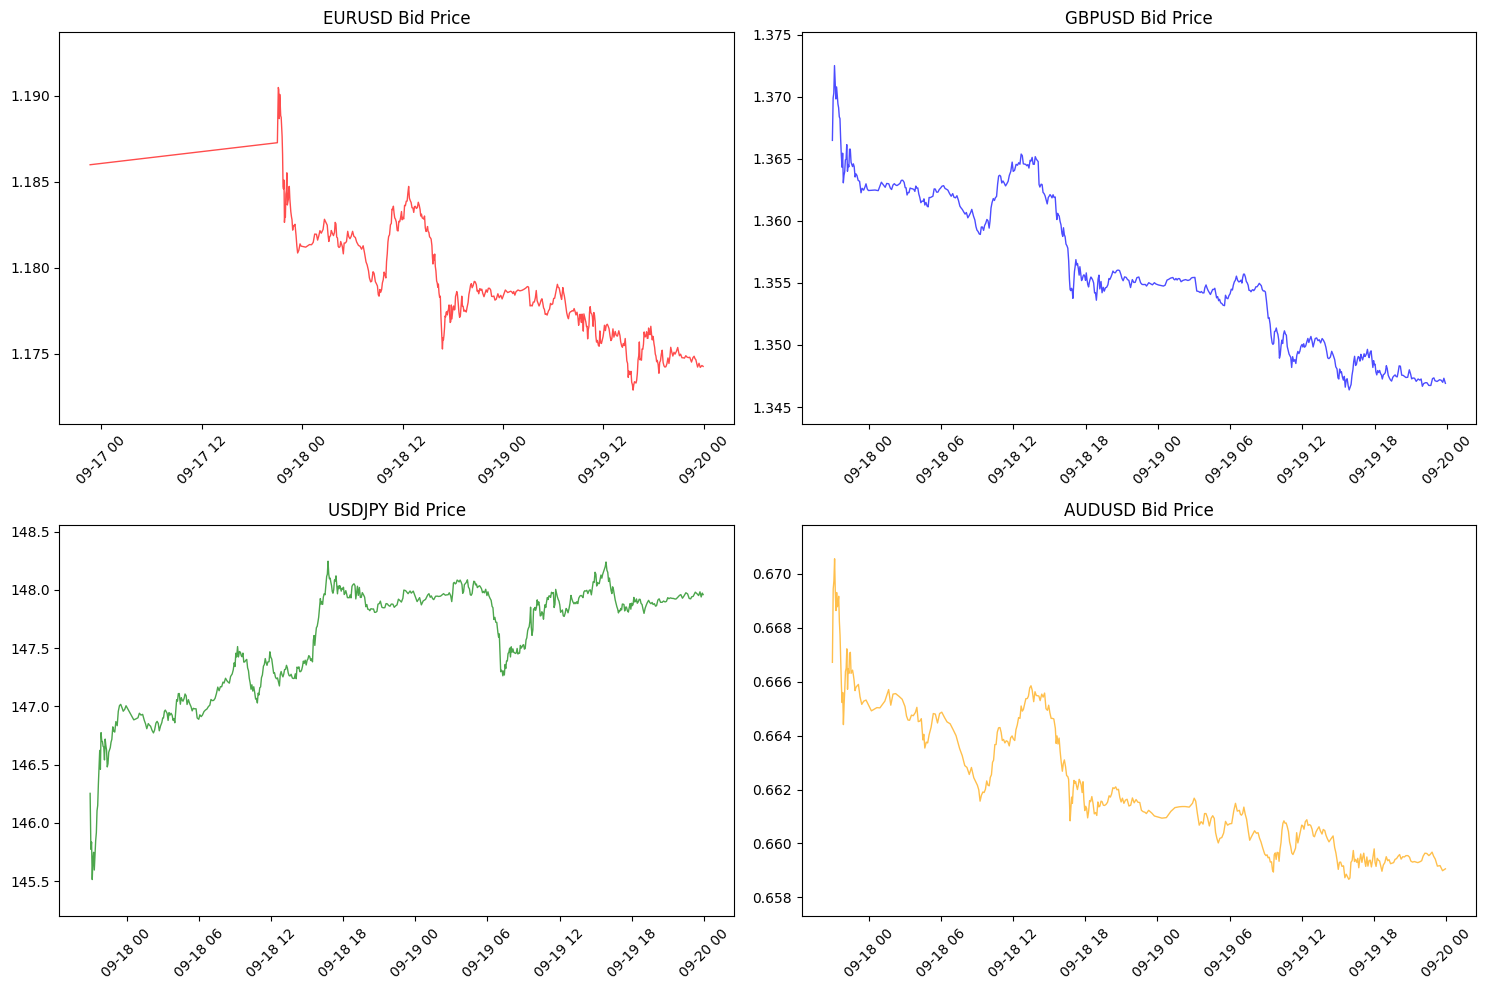

📈 Preisbewegungen aller verfügbaren Währungspaare visualisiert


In [8]:
# Cell 7: Multi-Symbol-Vergleich
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

symbols_to_compare = ['EURUSD', 'GBPUSD', 'USDJPY', 'AUDUSD']
colors = ['red', 'blue', 'green', 'orange']

for i, symbol in enumerate(symbols_to_compare):
    if symbol in symbols:
        row = i // 2
        col = i % 2
        
        data = loader.load_symbol_data(symbol)
        sample = data.iloc[::200]  # Sampling für Performance
        
        axes[row, col].plot(sample['timestamp'], sample['bid'], 
                           color=colors[i], alpha=0.7, linewidth=1)
        axes[row, col].set_title(f'{symbol} Bid Price')
        axes[row, col].tick_params(axis='x', rotation=45)
        
        # Y-Achse für bessere Vergleichbarkeit
        price_range = data['bid'].max() - data['bid'].min()
        mid_price = (data['bid'].max() + data['bid'].min()) / 2
        margin = price_range * 0.1
        axes[row, col].set_ylim(mid_price - price_range/2 - margin, 
                               mid_price + price_range/2 + margin)

plt.tight_layout()
plt.show()

print("📈 Preisbewegungen aller verfügbaren Währungspaare visualisiert")

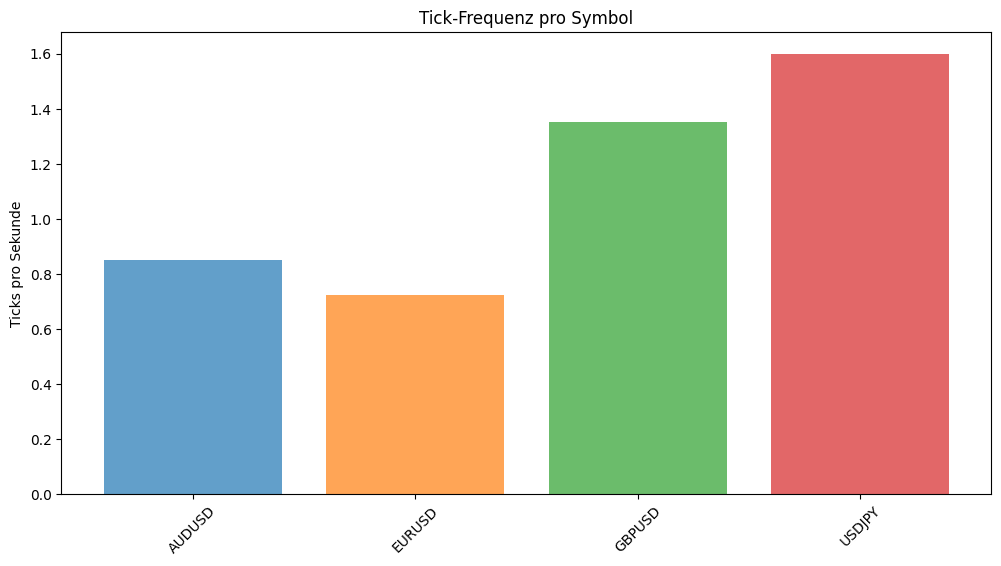

🔍 Datenqualitäts-Übersicht:
AUDUSD: 155,727 ticks, 0.85 ticks/sec, 3.1MB
EURUSD: 190,912 ticks, 0.72 ticks/sec, 3.8MB
GBPUSD: 247,795 ticks, 1.35 ticks/sec, 4.7MB
USDJPY: 293,378 ticks, 1.60 ticks/sec, 5.5MB


In [10]:
# Cell 8: Tick-Frequenz-Analyse
plt.figure(figsize=(12, 6))

for symbol in symbols:
    info = summary[symbol]
    if 'error' not in info:
        tick_freq = info['statistics']['tick_frequency_per_second']
        plt.bar(symbol, tick_freq, alpha=0.7)

plt.title('Tick-Frequenz pro Symbol')
plt.ylabel('Ticks pro Sekunde')
plt.xticks(rotation=45)
plt.show()

# Datenqualitäts-Übersicht
print("🔍 Datenqualitäts-Übersicht:")
for symbol, info in summary.items():
    if 'error' not in info:
        print(f"{symbol}: {info['total_ticks']:,} ticks, "
              f"{info['statistics']['tick_frequency_per_second']:.2f} ticks/sec, "
              f"{info['file_size_mb']:.1f}MB")